    Program to calculate depths from empty aperture simulation results

In [17]:
import numpy as np
import math
import astropy.table
import matplotlib as mpl
import matplotlib.pyplot as plt
import os,random,time
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
import scipy.stats as ss
from astropy.modeling import models, fitting
import sys
from array import array
import pylab as pl
from IPython.display import IFrame
import depthcalc
import calculatin as calc

so let me outline what I want to do: for a given fits file that I'm analyzing:
1. read in a list of filenames from the eAA program
2. for each file (ap size) in that list, calculate the associated 5sigma depth and output it (append it to an array or dictionary)
3. for each file (ap size) produce a histogram of the data and a gaussian fit to it, then output the gaussian fit parameters (AND the histogram parameters, so I can plot them later all at once instead of one at a time?)
4. for each fits file I'm analyzing, calculate the rms--I don't think I can do this step without uploading .fits files, though, so consider doing it on the computer and making a lil file with all the rms functions in it that can be access later
5. for each object in list1, produce a plot of all the histograms/gaussian fits on top of each other
6. for each fits file I'm analyzing, produce a sigma-vs-linear-size plot (Labbe-esque

after looping through each object in the list, I will have a file of depth measurements, gaussian fits, and (maybe) histogram parameters, as well as the aperture sizes. then I want to
1. display all the histograms, with the x and y axis fixed so the fwhm change is visible; on top of each other would be good
2. plot the sigma-from-gaussian-fitting versus linear-size-of-apertures plot from Labbe 03 and overplot a y=mx+b relation for the gaussian rms (rms per pixel/size unit, * the linear-size-of-apertures, I assume. or a huge range in x/pixel/size, that's okay too)
3. make depth as a function of aperture size plot (basically the same as 2, but with the magnitudes instead of the sigmas and arcsec aps instead of linear size/pixels

So I need two parts to the program: one part that loops through the files in the filename list, and appends all the outputs; and another part that deals with the bulk outputs

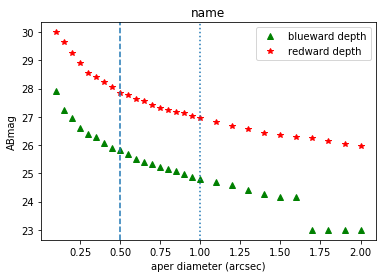

In [58]:
file1='../emptyApertureAnalysis_share/aperflux/allmost2_j0035_f814wu_osnn3m_aps.txt'
file2='../emptyApertureAnalysis_share/aperflux/all_j0035_f140w_osnn3m_aps_v30.txt'
filenames1=np.loadtxt(file1,dtype='str')
filenames2=np.loadtxt(file2,dtype='str')

originalfits1='../../HSTdata/j003548m4312/j003548m4312-f814wu_drc_sci.fits'
originalfits2='../../HSTdata/j003548m4312/j003548m4312-f140w_drz_sci.fits'
hdu1=fits.open(originalfits1)
hdu2=fits.open(originalfits2)
hdr1=hdu1[0].header
hdr2=hdu2[0].header
holdphots1=[hdr1['PHOTFLAM'],hdr1['PHOTPLAM']]
holdphots2=[hdr2['PHOTFLAM'],hdr2['PHOTPLAM']]
hdu1.close()
hdu2.close()

#arcsec
apers=np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
#linear size: linearsize=0.5*np.array(apers)/pixscale 
aper1 = 0.5*apers/0.1
aper1b =0.5*apers/0.05

mags_fblue=[]
mags_fred=[]
sigs_fblue=[]
sigs_fred=[]
histogram_fblue={}
histogram_fred={}
keynames_fblue=[]
keynames_fred=[]

for x in filenames1:
#    infile='../emptyApertureAnalysis_share/aperflux/'+str(x)
    infile=str(x)
    mags,sigs=depthcalc.depth(infile,holdphots1)
    mags_fblue.append(mags)
    sigs_fblue.append(sigs)
    holdhists1,nameout1=depthcalc.fithists(infile,binnum=100)
    histdict1={nameout1:holdhists1}
    histogram_fblue.update(histdict1)
    keynames_fblue.append(nameout1)
    
#this is only necessary for the bluward j003548m4312, which timed out after 24 hours for F814w
holdthese=[23.0,23.0,23.0,23.0]
for i in holdthese:
#    sigs_fblue.append(0)
    mags_fblue.append(i)
shortie=len(sigs_fblue)
aper1b=aper1b[0:shortie]


for y in filenames2:
#    infile2='../emptyApertureAnalysis_share/aperflux/'+str(y)
    infile2=str(y)
    mags2,sigs2=depthcalc.depth(infile2,holdphots2)
    mags_fred.append(mags2)
    sigs_fred.append(sigs2)
    holdhists2,nameout2=depthcalc.fithists(infile2,binnum=100)
    histdict2={nameout2:holdhists2}
    histogram_fred.update(histdict2)
    keynames_fred.append(nameout2)

plt.plot(apers,mags_fblue,'g^',label='blueward depth')
plt.plot(apers,mags_fred,'r*',label='redward depth')
plt.title('name')
plt.axvline(x=1.0,linestyle=':')
plt.axvline(x=0.50,linestyle='--')
#plt.hlines(y=29.5,xmin=0,xmax=2.0,linestyle=':')
plt.xlabel('aper diameter (arcsec)')
plt.ylabel('ABmag')
plt.legend(loc='upper right')
#plt.show()


okay that brings out all the data. now to plot, below

In [45]:
###########Plotting/turning things into LabbePlots
#set up plotting inputs
apers=np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])

#bluedata
fits_scib='../../HSTdata/j142632p3508/j142632p3508-f814w_drc_sci_newnorm3.fits'
fits_maskb='../../HSTdata/j142632p3508/j160116m0029-f814w_drc_sci_mask.fits'
fits_segb='../../HSTdata/j142632p3508/j160116m0029_f814w_seg_newnorm3.fits'
#reddata
fits_sci='../../HSTdata/j142632p3508/j160116m0029-f160w_drz_sci_newnorm3.fits'
fits_mask='../../HSTdata/j142632p3508/j160116m0029-f160w_drz_sci_mask.fits'
fits_seg='../../HSTdata/j142632p3508/j160116m0029_f160w_seg_newnorm3.fits' 

####Labbe03 plot setup
#calculate the RMS of the original science images
rmss,aper1=depthcalc.rmscalc(fits_sci,fits_mask,fits_seg,apers,pixscale=0.1)
rmsvals=rmss*aper1
print('RMS of original sci image, redward',rmss)


rmssb,aper1b=depthcalc.rmscalc(fits_scib,fits_maskb,fits_segb,apers,pixscale=0.05)
rmsvalsb=rmssb*aper1b
print('RMS of original sci image, blueward',rmssb)

#add the standard deviation from the Gaussian fits
#sigvals=[]
#for i in keynames_fred:
#    obj=histogram_fred[i]
#    sigvals.append(obj['bestfit'].stddev.value)
#    
#sigvalsb=[]
#for j in keynames_fblue:
#    ob=histogram_fblue[j]
#    sigvalsb.append(ob['bestfit'].stddev.value)



IOError: [Errno 2] No such file or directory: '../../HSTdata/j142632p3508/j160116m0029-f160w_drz_sci_newnorm3.fits'

poly2 red
Model: Polynomial1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Degree: 2
Parameters:
     c0          c1                    c2         
    --- -------------------- ---------------------
    0.0 0.018744524229357504 0.0012651852137136803
poly2 blue
Model: Polynomial1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Degree: 2
Parameters:
     c0          c1                   c2         
    --- ------------------- ---------------------
    0.0 0.01770310753993333 0.0009222862490271245


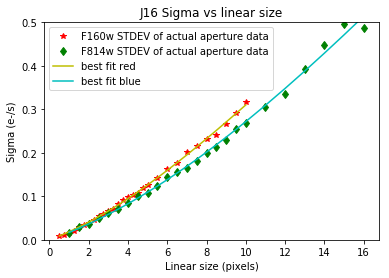

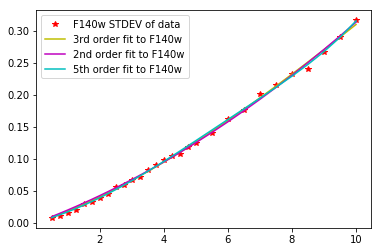

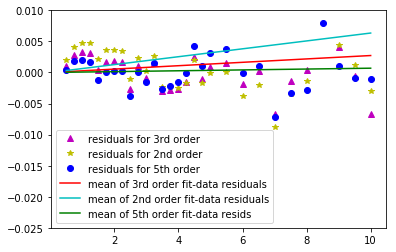

In [60]:
########OKAY, now to fitting the sigs_fred and sigs_fblue
#Labbe fits a 2nd order polynomial
#standard procedure is define model, define fitter, and fit the data (http://learn.astropy.org/rst-tutorials/Models-Quick-Fit.html)
# maybe try a couple different fitters and see if the reduced chi squared value is better for different one (use calculatin.py)

model_poly=models.Polynomial1D(degree=3,c0=0.0)
model_poly.c0.fixed=True
fitter_poly=fitting.LinearLSQFitter()
best_fit_poly_red = fitter_poly(model_poly, aper1, sigs_fred)


model2=models.Polynomial1D(degree=2,c0=0.0)
model2.c0.fixed=True
model5=models.Polynomial1D(degree=5,c0=0.0)
model5.c0.fixed=True
best_fit_poly_red2 = fitter_poly(model2,aper1,sigs_fred)
best_red5=fitter_poly(model5,aper1,sigs_fred)
best_fit_poly_blue = fitter_poly(model_poly,aper1b,sigs_fblue)
best_fit_poly_blue2= fitter_poly(model2,aper1b,sigs_fblue)
best_blue5=fitter_poly(model5,aper1b,sigs_fblue)
print('poly2 red')
print(best_fit_poly_red2)
print('poly2 blue')
print(best_fit_poly_blue2)

#print(best_fit_poly_blue)
#NOTE: apparently this doesn't fit as well if you feed apers instead of aper1 and aper1b

#plt.plot(aper1,sigvals,'m^',label='F160w STDEV of Gaussian fit to histogram')
plt.plot(aper1,sigs_fred,'r*',label='F160w STDEV of actual aperture data')
#plt.plot(aper1b,sigvalsb,'bo',label='F814w STDEV of Gaussian fit to hist')
plt.plot(aper1b,sigs_fblue,'gd',label='F814w STDEV of actual aperture data')
#how do I fit the results of bestfitpoly?
plt.plot(aper1,best_fit_poly_red(aper1),color='y',label='best fit red')
plt.plot(aper1b,best_fit_poly_blue(aper1b),color='c',label='best fit blue')
plt.title('J16 Sigma vs linear size')
plt.xlabel('Linear size (pixels)')
plt.ylabel('Sigma (e-/s)')
#plt.plot(aper1b,rmsvalsb,label='Gaussian noise F814w') #replace second xvals with rmsvals once rmsvals are calculated and added to github
#plt.plot(aper1,rmsvals,label='Gaussian noise F160w')
plt.legend(loc='upper left')
#plt.yscale('log')
plt.ylim(bottom=0,top=0.5)
#plt.xlim(left=0,right=100)
#plt.savefig('j16_problemwithlabbeplot2.png')
plt.show()


plt.plot(aper1,sigs_fred,'r*',label='F140w STDEV of data')
plt.plot(aper1,best_fit_poly_red(aper1),color='y',label='3rd order fit to F140w')
plt.plot(aper1,best_fit_poly_red2(aper1),color='m',label='2nd order fit to F140w')
plt.plot(aper1,best_red5(aper1),color='c',label='5th order fit to F140w')
plt.legend(loc='upper left')
plt.show()
plt.plot(aper1,(best_fit_poly_red(aper1)-sigs_fred),'m^',label='residuals for 3rd order')
plt.plot(aper1,(best_fit_poly_red2(aper1)-sigs_fred),'y*',label='residuals for 2nd order')
plt.plot(aper1,(best_red5(aper1)-sigs_fred),'bo',label='residuals for 5th order')
plt.plot(aper1,(aper1*np.mean(best_fit_poly_red(aper1)-sigs_fred)),color='r',label='mean of 3rd order fit-data residuals')
plt.plot(aper1,(aper1*np.mean(best_fit_poly_red2(aper1)-sigs_fred)),color='c',label='mean of 2nd order fit-data residuals')
plt.plot(aper1,(aper1*np.mean(best_red5(aper1)-sigs_fred)),color='g',label='mean of 5th order fit-data resids')
plt.legend(loc='lower left')
plt.ylim(bottom=-0.025,top=0.01)
plt.show()


WARNING: Below here is experimental DOES NOT WORK

In [4]:
###################Run the analysis
#set up the input
filelist='../emptyApertureAnalysis_share/aperflux/irc0218_f160w_newnorm3.txt'
file2='../emptyApertureAnalysis_share/aperflux/irc0218_f160w_newnorm2.txt'
filenames=np.loadtxt(file2,dtype='str')
filenames2=np.loadtxt(filelist,dtype='str')
fits_original='../../HSTdata/uds_xmmlss0218/uds-100mas-f160w_drz_sci.fits'
hdu1=fits.open(fits_original)
hdr1=hdu1[0].header
photflam=hdr1['PHOTFLAM']
photplam=hdr1['PHOTPLAM']

hold_photvals=[photflam,photplam]
hdu1.close()

######set up output
abmags_old=[]
abmags_new=[]
sigs_old=[]
sigs_new=[]
histogram_old={}
histogram_new={}
keynames_old=[]
keynames_new=[]


#run 
for x in filenames:
    histdict={}
    infile='../emptyApertureAnalysis_share/aperflux/'+str(x)
    mags,sigs=depthcalc.depth(infile,hold_photvals)
    holdhists,nameout=depthcalc.fithists(infile,binnum=100)
    abmags_old.append(mags)
    sigs_old.append(sigs)
    histdict={nameout:holdhists}
    histogram_old.update(histdict)
    keynames_old.append(nameout)
    
for y in filenames2:
    histdict2={}
    infile='../emptyApertureAnalysis_share/aperflux/'+str(y)
    mags2,sigs2=depthcalc.depth(infile,hold_photvals)
    holdhists2,nameout2=depthcalc.fithists(infile,binnum=100)
    abmags_new.append(mags2)
    sigs_new.append(sigs2)
    histdict2={nameout2:holdhists2}
    histogram_new.update(histdict2)
    keynames_new.append(nameout2)
    
apers=np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])

fits_sci='../../HSTdata/uds_xmmlss0218/uds_f160w_trim_newnorm3.fits'
fits_mask='../../HSTdata/uds_xmmlss0218/uds_f160w_trim_mask.fits'
fits_seg='../../sextractor-2.19.5/irc0218_f160w_seg_newnorm3.fits' #hmm, don't know if i made a seg for v9_newnorm


#ABmag depth plot
plt.plot(apers,abmags_old,'r*')
plt.title('IRC0218 ABmag with newnorm2')
plt.axvline(x=1.0,linestyle=':')
#plt.hlines(y=29.5,xmin=0,xmax=2.0,linestyle=':')
plt.xlabel('aper diameter (arcsec)')
plt.ylabel('ABmag')
plt.show()

plt.plot(apers,abmags_new,'r*')
plt.title('IRC0218 ABmag as a function of aperture, newnorm3')
plt.axvline(x=1.0,linestyle=':')
plt.xlabel('aper diameter (arcsec)')
plt.ylabel('ABmag')
plt.show()
    


IOError: ../emptyApertureAnalysis_share/aperflux/irc0218_f160w_newnorm2.txt not found.

16.402000172484


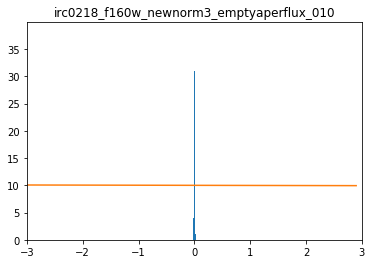

10.021630726019971


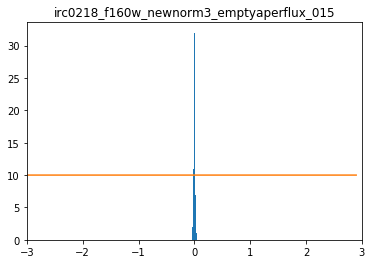

11.92622573568481


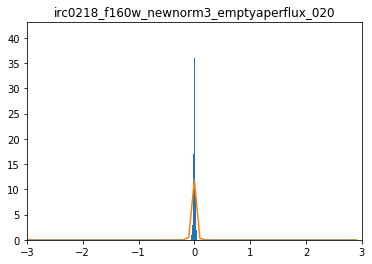

32.832280109101355


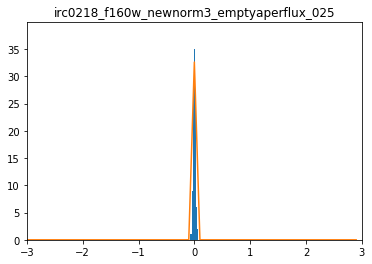

29.423172371612218


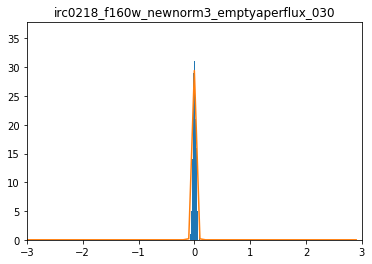

28.90261697960551


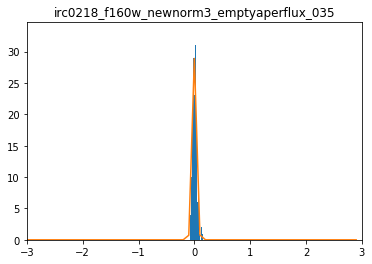

47.40445222074015


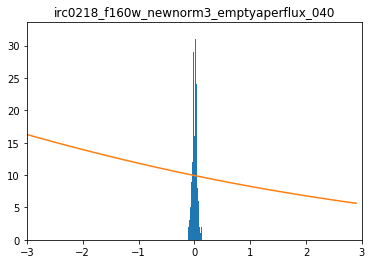

27.611497470930978


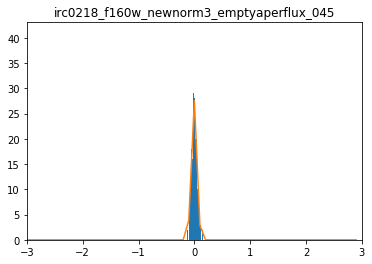

28.59995571152871


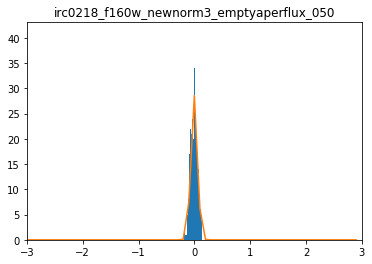

31.09574677046014


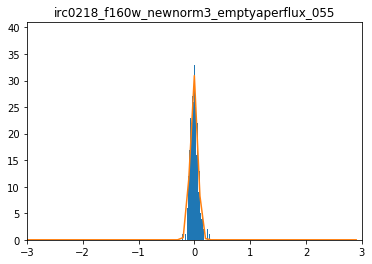

30.223391731677633


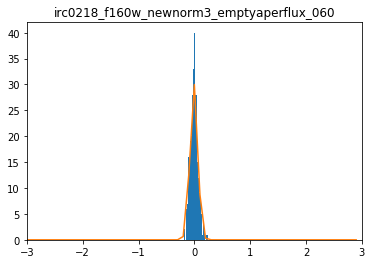

27.890128705231426


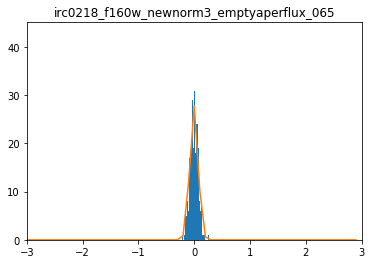

41.78337811516845


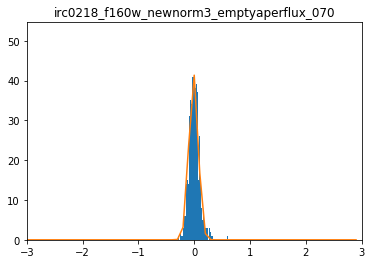

33.259628338746616


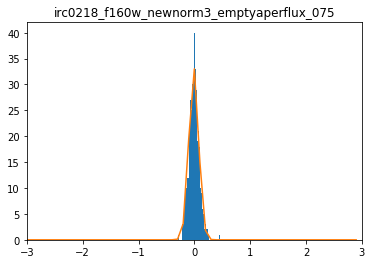

32.98695267726602


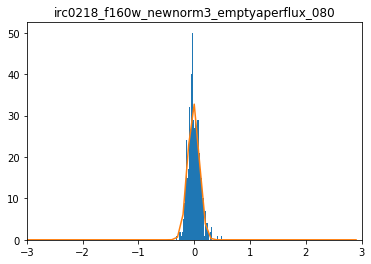

36.738088794887965


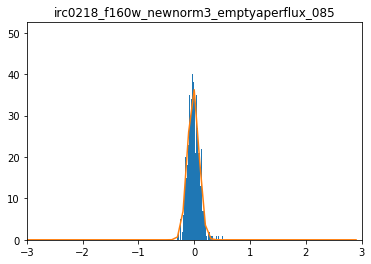

28.407551456867992


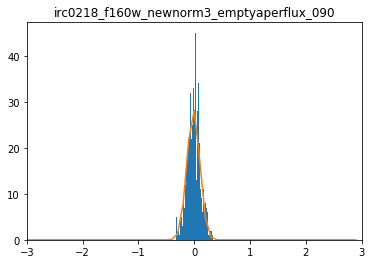

32.6096412489111


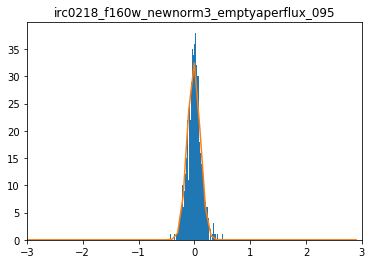

32.510695763138884


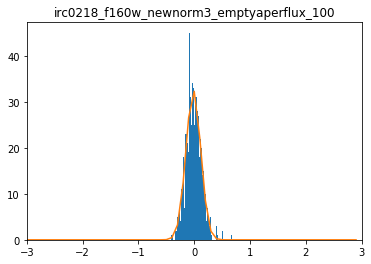

34.794026316567475


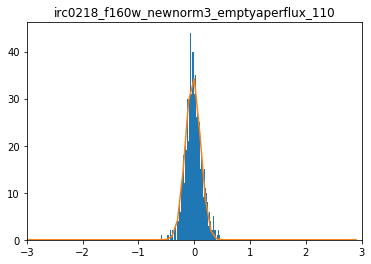

43.57153583957138


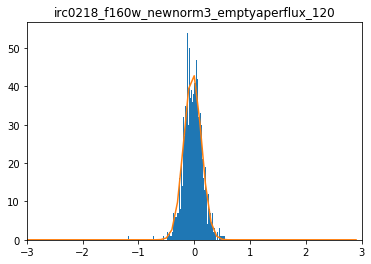

39.934748021747794


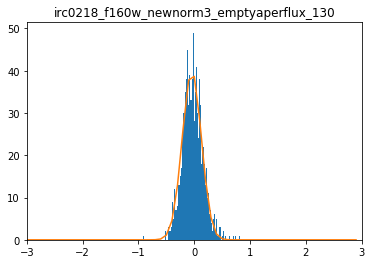

38.384198833995406


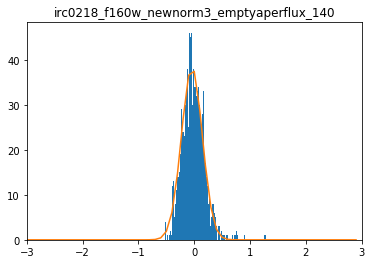

35.86659685337841


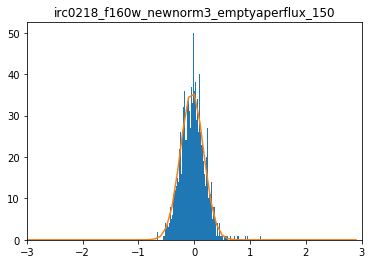

37.17505206042838


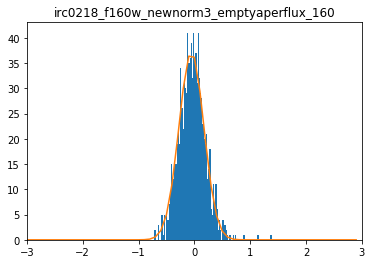

37.108485758395695


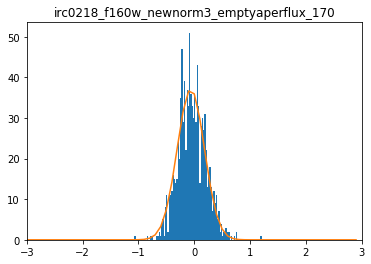

51.86035988241899


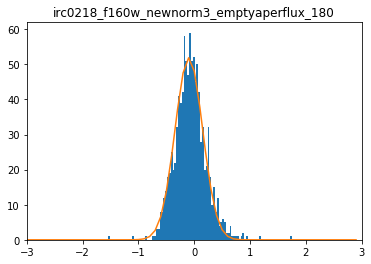

34.58666071656863


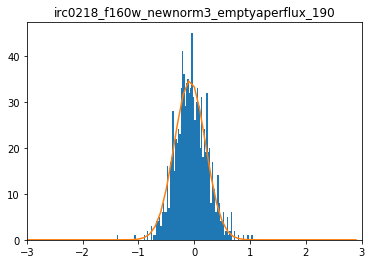

42.11870937533867


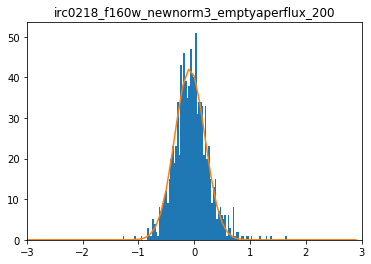

In [5]:
######plotting histograms and their gaussian fits
#this part isn't QUITE working right but given 
#that I've extracted the fit to the data and used it in Labbe-esque plot above, is it necessary? might be nice tho 
#FIX LATER

def gas(x,a,b,c):
    top=-0.5*((x-b)**2.0)
    bottom=c*c
    out=a*np.exp(top/bottom)
    return out

xpts=np.arange(-3,3,0.1)
for y in keynames_new:
    binns=histogram_new[y]['bins']
    data=histogram_new[y]['hist1']
    bestfitp=histogram_new[y]['bestfit']
    print(bestfitp.amplitude.value)
    amps=histogram_new[y]['bestfit'].amplitude.value
    mn=histogram_new[y]['bestfit'].mean.value
    stde=histogram_new[y]['bestfit'].stddev.value
    yvals=gas(xpts,amps,mn,stde)
    plt.clf()
    plt.hist(data,100)
    plt.plot(xpts,yvals)
    plt.xlim([-3,3])
    plt.title(y)
    plt.show()
        #plt.plot(binns[0:np.size(binns)-1],bestfitp[0:np.size(binns)-1])
    
    #okay, displaying individual gaussian fits is a pain in the butt--normally I'd just plt.plot(bins,bestfit(bins))
    #but that isn't working for whatever reason. bestfit is somehow a 1d gaussian thing that plt.plot can't handle

don't need to run anything below this

In [ ]:
#########the part of the program that does the calculations
def depthcalc(totfile,photvals):
    infile=totfile
    valsin=np.loadtxt(infile,dtype=float,delimiter='\t',usecols=2,comments='#')
    tmpfile=infile
    tmplist=tmpfile.split('/')
    tmpname=tmplist[len(tmplist)-1]
    outname=tmpname.replace('.dat','')
    
    #########calculate average flux and stdev
    stdev_empty=np.std(valsin)
    avg_emptyflux=np.average(valsin)
    #########gaussian fit to histogram
    binnys=100
    #n,bins,patchs=plt.hist(valsin,binnys)
    hist1,bins1=np.histogram(valsin,binnys)
       
    
    #I want it to produce n, bins, and patches but I don't want it to actually plot
    #fit a gaussian to the resultant data
    holdhist={}
    model=models.Gaussian1D()
    fitter=fitting.LevMarLSQFitter()
    bestfit=fitter(model,bins1[0:(len(bins1)-1)],hist1)  #[0:np.size(bins)-1],n)
       #how do I output the parameters for fitting later? maybe just bestfit? or n,bins,patchs as well?
    holdhist={'hist1':valsin,'bins':bins1,'bestfit':bestfit}
    
    #do the fitting and save it to a file?
    #outfile=outname+str('.pdf')
    #plt.figure()
    #plt.hist(valsin,binnys)
    #plt.plot(bins1[0:np.size(bins1)-1],bestfit(bins1[0:np.size(bins1)-1]))
    #plt.title(outname)
    #plt.xlabel('electrons/s (intrinsic HST brightness in the filter)')
    #plt.ylabel('counts')
    #plt.savefig(outfile)
    #plt.close()

    #########set up parameters
    temp_photflam=photvals[0]
    temp_photplam=photvals[1]
    #########calculate abmag
    abmagzpt=-2.5*np.log10(temp_photflam) - 21.10 - 5.0*np.log10(temp_photplam) + 18.692
    abmag=-2.5*np.log10(5.0*stdev_empty)+abmagzpt
    
    return abmag,stdev_empty,holdhist,outname